# Reduced Order Models

## Preliminaries

In [84]:
import sys
sys.path.insert(0, "/home/ubuntu/symmathSBML")
import control as c
from controlSBML.control_sbml import ControlSBML
import controlSBML.constants as cn
try:
    from symmathSBML.symmath_sbml import SymmathSBML
except:
    pass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te

import os
import urllib.request

In [2]:
MODELS = ["LINEAR_MDL", "NONLINEAR1_MDL", "NONLINEAR2_MDL"]

## Antimony Models

Here we present 3 variations of a sequential pathway.
* LINEAR_MDL: The kinetics result in a linear system of ODEs
* NONLINEAR1_MDL: There is one quadratic rate law, affecting $S_2$, $S_3$
* NONLINEAR2_MDL: There are two quadratic rate laws, affecting $S_1$, $S_2$,$S_3$.

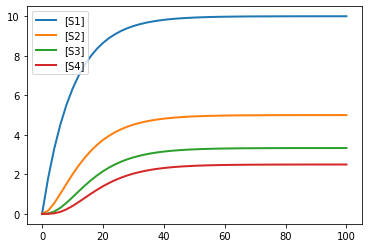

In [3]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
LINEAR_MDL = """
$S0 -> S1; $S0
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3
S4 -> $S5; k4*S4

k1 = 0.1
k2 = 0.2
k3 = 0.3
k4 = 0.4
S0 = 1
S1 = 0
S2 = 0
S3 = 0
S4 = 0
S5 = 0
"""
LINEAR_RR = te.loada(LINEAR_MDL)
LINEAR_RR.plot(LINEAR_RR.simulate(0, 100))

In [4]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
NONLINEAR1_MDL = """
//S0 -> 2 S0; S0
$S0 -> S1; $S0
S1 -> S2; k2*S1
S2 -> ; k3*S2*S1

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""
NONLINEAR1_RR = te.loada(NONLINEAR1_MDL)
#NONLINEAR1_RR.plot(NONLINEAR1_RR.simulate())

In [5]:
NONLINEAR1_RR.reset()
NONLINEAR1_RR.getFullJacobian()

      S1,  S2
S1 [[ -1,   0],
S2  [  1, -10]]

In [6]:
ctlsb = ControlSBML(NONLINEAR1_MDL)
ctlsb.jacobian

,S0,S1,S2
S0,0.0,0.0,0.0
S1,1.0,-1.0,0.0
S2,0.0,1.0,-10.0


In [7]:
ctlsb = ControlSBML(NONLINEAR1_MDL)
ctlsb.jacobian
ctlsb.jacobian

,S0,S1,S2
S0,0.0,0.0,0.0
S1,1.0,-1.0,0.0
S2,0.0,1.0,-10.0


In [8]:
NONLINEAR1_RR.getBoundarySpeciesIds()

['S0']

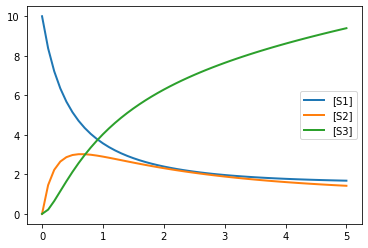

In [9]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
NONLINEAR2_MDL = """
//S0 -> 2 S0; S0
$S0 -> S1; $S0
S1 -> S2; k2*S1*S1
S2 -> S3; k3*S2*S1

k1 = 0.1
k2 = 0.2
k3 = 0.3
k4 = 0.4
S0 = 0.5
k0 = 1
S1 = 10
S2 = 0
S3 = 0
"""
NONLINEAR2_RR = te.loada(NONLINEAR2_MDL)
NONLINEAR2_RR.plot(NONLINEAR2_RR.simulate())

# Helper Functions

In [88]:
def getSharedCodes(module_name="util"):
    """
    Obtains common codes from the github repository.

    Parameters
    ----------
    module_name: str
        name of the python module in the src directory
    """
    #url = "https://github.com/sys-bio/network-modeling-summer-school-2021/raw/main/src/%s.py" % moduleName
    url = "https://github.com/ModelEngineering/controlSBML/raw/main/controlSBML/%s.py" % module_name
    local_python = "python.py"
    _, _ = urllib.request.urlretrieve(url=url, filename=local_python)
    with open(local_python, "r") as fd:
        codeStr = "".join(fd.readlines())
    print(codeStr)
    exec(codeStr, globals())

# Acquire codes
getSharedCodes()

# TESTS
assert(isinstance(LINEAR_PATHWAY_DF, pd.DataFrame))

"""Support Utilities."""

import numpy as np
import pandas as pd


def calculateMatrixDistance(mat1, mat2):
    """
    Calculates the distance between two matrices with the same shape.

    Parameters
    ----------
    mat1 - np.array
    mat2 - np.array
    
    Returns
    -------
    float
    """
    if np.shape(mat1) != np.shape(mat2):
        raise ValueError("Matrices must be the same shape.")
    return np.sum( (mat1 - mat2)**2)



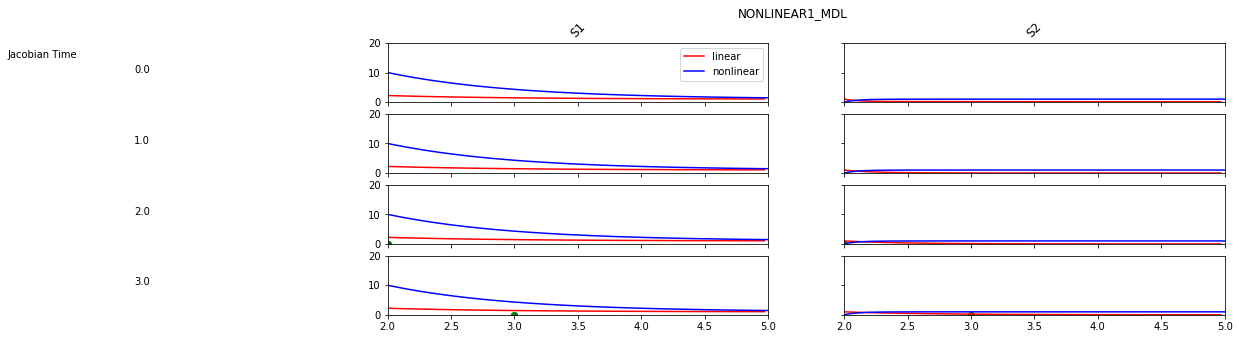

OK!


In [10]:
def evaluateAccuracy(sbml_model, timepoints, suptitle="", is_plot=True, start_time=0, end_time=5, y_max=None, ymin=0):
    if isinstance(timepoints, float) or isinstance(timepoints, int):
        timepoints = [timepoints]
    ctlsb = ControlSBML(sbml_model)
    rr_df = ctlsb.simulateRoadrunner(start_time, end_time)
    nrow = len(timepoints)
    ncol = len(rr_df.columns)
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 5))
    axes = np.reshape(axes, (nrow, ncol))
    for irow, timepoint in enumerate(timepoints):
        linear_df = ctlsb.simulateLinearSystem(timepoint=timepoint, start_time=start_time, end_time=end_time)
        if y_max is None:
            ymax_val = max(linear_df.max().max(), rr_df.max().max())
        else:
            ymax_val = y_max
        for icol, column in enumerate(rr_df.columns):
            ax = axes[irow, icol]
            ax.plot(linear_df.index, linear_df[column], color="red")
            ax.plot(rr_df.index, rr_df[column], color="blue")
            ax.scatter([timepoint], [ymin], s=40, marker="o", color="g")
            ax.set_xlim([start_time, end_time])
            ax.set_ylim([0, ymax_val])
            if irow < nrow - 1:
                ax.set_xticklabels([])
            if irow == 0:
                ax.set_title(column, rotation=45)
                if icol == 0:
                    ax.text(start_time-3, 0.75*ymax_val, "Jacobian Time")
                    ax.legend(["linear", "nonlinear"])
            if icol > 0:
                ax.set_yticklabels([])
            else:
                ax.text(start_time-2, ymax_val/2, "%2.1f" % timepoint)
    plt.suptitle(suptitle)
    if is_plot:
        plt.show()
    else:
        plt.close()
    
# Tests
suptitle = "NONLINEAR1_MDL"
evaluateAccuracy(NONLINEAR1_MDL, [0, 1, 2, 3], suptitle=suptitle, start_time=2, y_max=20,  is_plot=True)
print("OK!")

# Model Reductions

In [11]:
ctlsb = ControlSBML(LINEAR_RR)

## Eigenvalues and eigenvectors of the Jacobian

In [12]:
A = ctlsb.jacobian
A_mat = A.values
A

,S0,S1,S2,S3,S4,S5
S0,0.0,0.0,0.0,0.0,0.0,0.0
S1,1.0,-0.1,0.0,0.0,0.0,0.0
S2,0.0,0.1,-0.2,0.0,0.0,0.0
S3,0.0,0.0,0.2,-0.3,0.0,0.0
S4,0.0,0.0,0.0,0.3,-0.4,0.0
S5,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
U, S, V = np.linalg.svd(A_mat)

In [14]:
pd.DataFrame(U)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.0,1.0
1,-0.999945,-0.001085,-0.005875,-0.008569,0.0,0.0
2,0.010435,-0.077100,-0.532227,-0.843019,0.0,0.0
3,-0.000480,0.481424,0.720595,-0.498972,0.0,0.0
4,0.000057,-0.873090,0.444344,-0.200680,0.0,0.0
5,0.000000,0.000000,0.000000,0.000000,1.0,0.0


In [15]:
pd.DataFrame(np.identity(6) * S)

,0,1,2,3,4,5
0,1.005039,0.000000,0.000000,0.000000,0.0,-0.0
1,0.000000,0.547381,0.000000,0.000000,0.0,-0.0
2,0.000000,0.000000,0.322563,0.000000,0.0,-0.0
3,0.000000,0.000000,0.000000,0.161935,0.0,-0.0
4,0.000000,0.000000,0.000000,0.000000,0.0,-0.0
5,0.000000,0.000000,0.000000,0.000000,0.0,-0.0


In [16]:
pd.DataFrame(V)

,0,1,2,3,4,5
0,-0.994932,0.100531,-0.002172,0.000160,-0.000023,-0.0
1,-0.001983,-0.013887,0.204071,-0.742360,0.638012,-0.0
2,-0.018213,-0.163178,0.776794,-0.256928,-0.551018,-0.0
3,-0.052918,-0.515300,0.424920,0.552617,0.495705,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
5,-0.083519,-0.835188,-0.417594,-0.278396,-0.208797,-0.0


## Construct the reduced order model

We'll do this by using a new coordinate space.
This coordinate space eliminates the effects of smaller singular values.

We'll transform ${\bf A}$, and $n \times n$ matrix, to reduce the dimension to $m \times m$.
This is done using singular values.
Recall that the SVD  of a matrix is ${\bf A} = {\bf U} {\bf S}  {\bf V}$.
We construct
$\tilde{{\bf A}} = {\bf U} {\tilde {\bf S}} {\bf V}$
where we set to 0 the smaller singular values.

In [17]:
pd.DataFrame(A_mat)

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.1,0.0,0.0,0.0,0.0
2,0.0,0.1,-0.2,0.0,0.0,0.0
3,0.0,0.0,0.2,-0.3,0.0,0.0
4,0.0,0.0,0.0,0.3,-0.4,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
np.linalg.eig(A_mat)[0]

array([-0.4, -0.3, -0.2, -0.1,  0. ,  0. ])

In [19]:
pd.DataFrame(np.linalg.eig(A_mat)[1])

,0,1,2,3,4,5
0,0.0,0.000000,0.000000,0.0,0.083519,0.0
1,0.0,0.000000,0.000000,0.5,0.835188,0.0
2,0.0,0.000000,0.267261,0.5,0.417594,0.0
3,0.0,0.316228,0.534522,0.5,0.278396,0.0
4,1.0,0.948683,0.801784,0.5,0.208797,0.0
5,0.0,0.000000,0.000000,0.0,0.000000,1.0


In [20]:
def mkReducedOrderModel(A_mat, r):
    """
    Creates a reduced order model of dimension r.
    
    Parameters
    ----------
    A_mat: n X n matrix
    r: int (r < n)
    
    Returns
    -------
    A_tilde_mat: n X n
    """
    U_mat, S, V_mat = np.linalg.svd(A_mat)
    lst = [v if n < r else 0 for n, v in enumerate(S)]
    S_tilde = np.array(lst)
    df = pd.DataFrame(np.matmul(U * S_tilde, V_mat))
    df = df.applymap(lambda v: v if np.abs(v) > 0.0001 else 0)
    return df.values

# Tests
np.allclose(mkReducedOrderModel(A_mat, 5), A_mat)

True

In [21]:
U_mat, S, V_mat = np.linalg.svd(A_mat)
pd.DataFrame(V_mat)

,0,1,2,3,4,5
0,-0.994932,0.100531,-0.002172,0.000160,-0.000023,-0.0
1,-0.001983,-0.013887,0.204071,-0.742360,0.638012,-0.0
2,-0.018213,-0.163178,0.776794,-0.256928,-0.551018,-0.0
3,-0.052918,-0.515300,0.424920,0.552617,0.495705,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
5,-0.083519,-0.835188,-0.417594,-0.278396,-0.208797,-0.0


In [22]:
S

array([ 1.00503948,  0.54738122,  0.32256254,  0.16193472,  0.        ,
       -0.        ])

Note which species are most weighted for each coordinate.

In [23]:
pd.DataFrame(mkReducedOrderModel(A_mat, 6))

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.1,0.0,0.0,0.0,0.0
2,0.0,0.1,-0.2,0.0,0.0,0.0
3,0.0,0.0,0.2,-0.3,0.0,0.0
4,0.0,0.0,0.0,0.3,-0.4,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0


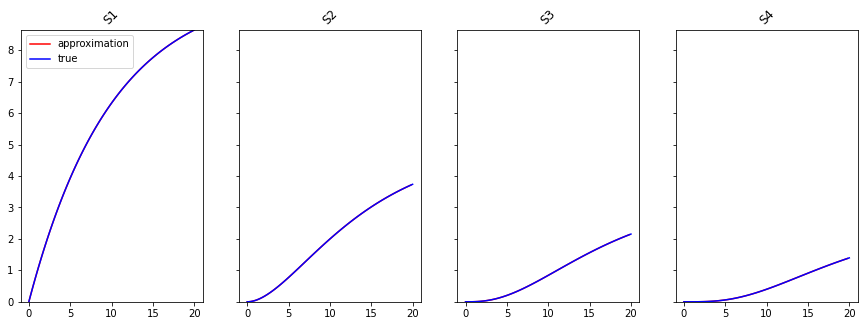

In [24]:
ctlsb.plotLinearApproximation(A_mat, end_time=20)

In [25]:
A5_mat = mkReducedOrderModel(A_mat, 5)
pd.DataFrame(A5_mat)

,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,-0.1,0.0,0.0,0.0,0.0
2,0.0,0.1,-0.2,0.0,0.0,0.0
3,0.0,0.0,0.2,-0.3,0.0,0.0
4,0.0,0.0,0.0,0.3,-0.4,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
np.linalg.eig(A5_mat)[0]

array([-0.4, -0.3, -0.2, -0.1,  0. ,  0. ])

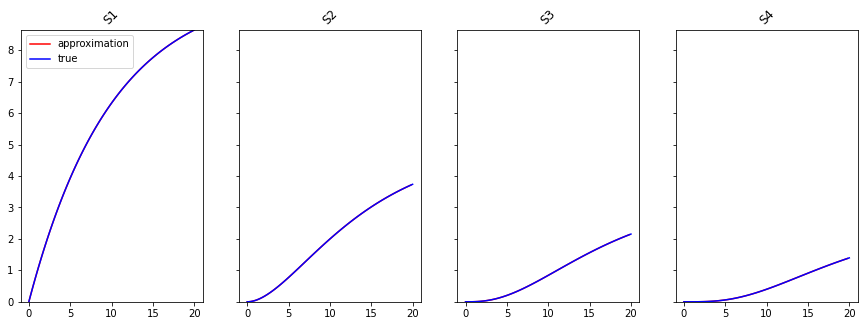

In [27]:
ctlsb.plotLinearApproximation(A5_mat, end_time=20)

In [28]:
A3_mat = mkReducedOrderModel(A_mat, 3)
pd.DataFrame(A3_mat)

,0,1,2,3,4,5
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.999927,-0.100715,0.000590,0.000767,0.000688,0.0
2,-0.007224,0.029654,-0.141992,0.075440,0.067671,0.0
3,-0.004276,-0.041637,0.234334,-0.255348,0.040053,0.0
4,-0.001720,-0.016746,0.013809,0.317958,-0.383891,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


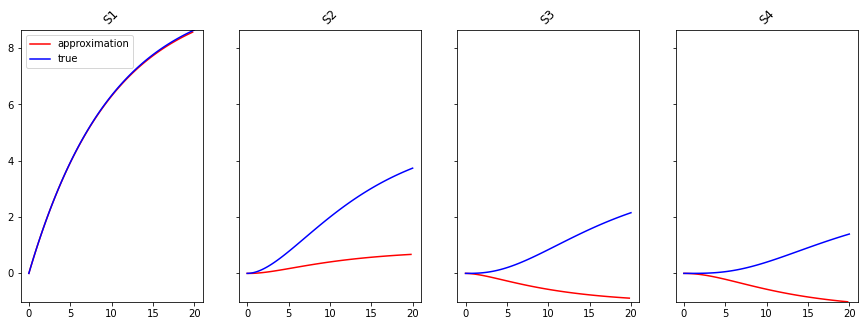

In [29]:
ctlsb.plotLinearApproximation(A3_mat, end_time=20)

**TO DO**
1. Analyze eigenvalues of the reduced matrix
1. What analysis should be done with reduced order systems?
   1. Analysis in new coordinate space of reduced dimension?
   1. Analyze the transformation vectors?

## Accuracy of Linear Model: Sequential Pathway

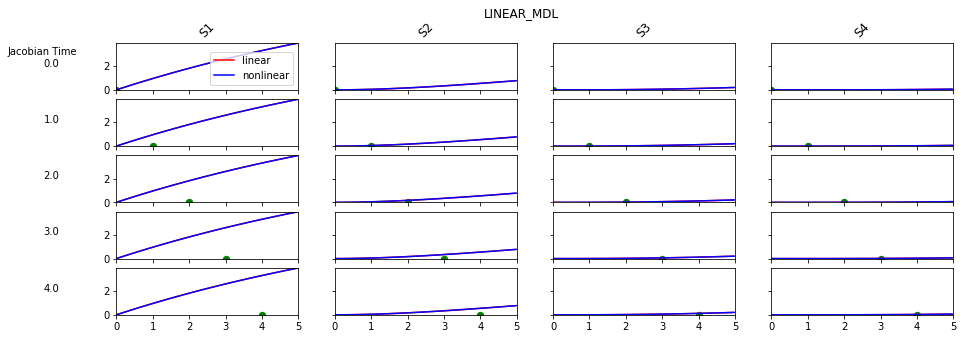

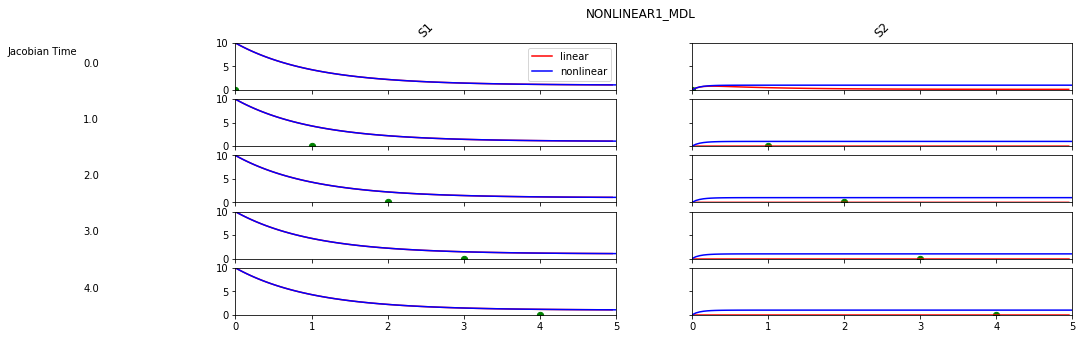

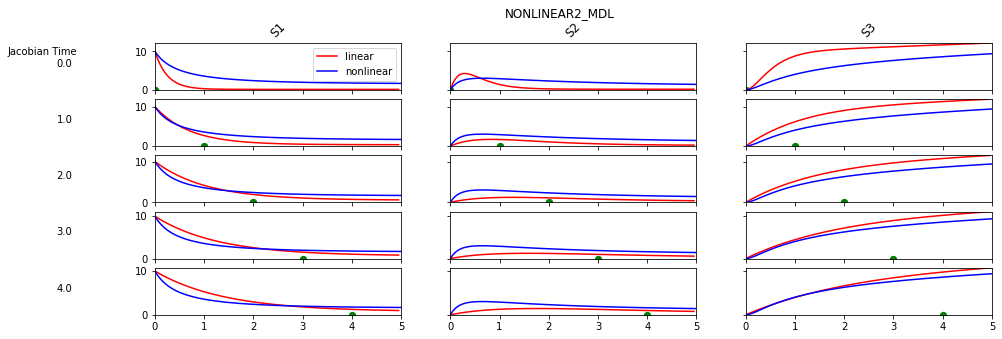

In [30]:
timepoints = range(5)
for name in ["LINEAR_MDL", "NONLINEAR1_MDL", "NONLINEAR2_MDL"]:
    mdl = eval(name)
    evaluateAccuracy(mdl, timepoints, suptitle=name, is_plot=True)

In [31]:
try:
    symmath = SymmathSBML(NONLINEAR2_MDL)
    symmath.jacobian_df
except:
    pass

**Notes**
1. For S0, the time at which the Jacobian is calculated doesn't matter since $\frac {\partial S_0}{S_n}$ is a constant (0).
1. $S_1$, $S_2$, $S_3$ have non-constant partial derivatives and so their Jacobian will change with the timepoint.

In [32]:
for mdl in MODELS:
    print("\n\n %s" % mdl)
    symmath = SymmathSBML(eval(mdl))
    print(symmath.getJacobian(is_sub_parameters=True, is_sub_others=True, is_sub_species=False))



 LINEAR_MDL
                   S0                  S1                  S2  \
S0  -1.00000000000000                   0                   0   
S1   1.00000000000000  -0.100000000000000                   0   
S2                  0   0.100000000000000  -0.200000000000000   
S3                  0                   0   0.200000000000000   
S4                  0                   0                   0   
S5                  0                   0                   0   

                    S3                  S4 S5  
S0                   0                   0  0  
S1                   0                   0  0  
S2                   0                   0  0  
S3  -0.300000000000000                   0  0  
S4   0.300000000000000  -0.400000000000000  0  
S5                   0   0.400000000000000  0  


 NONLINEAR1_MDL
                   S0                 S1       S2
S0  -1.00000000000000                  0        0
S1   1.00000000000000  -1.00000000000000        0
S2                  0     

# Wolf Model

In [33]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml")

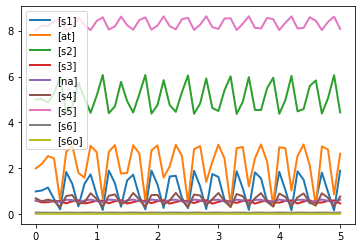

In [34]:
rr.plot(rr.simulate())

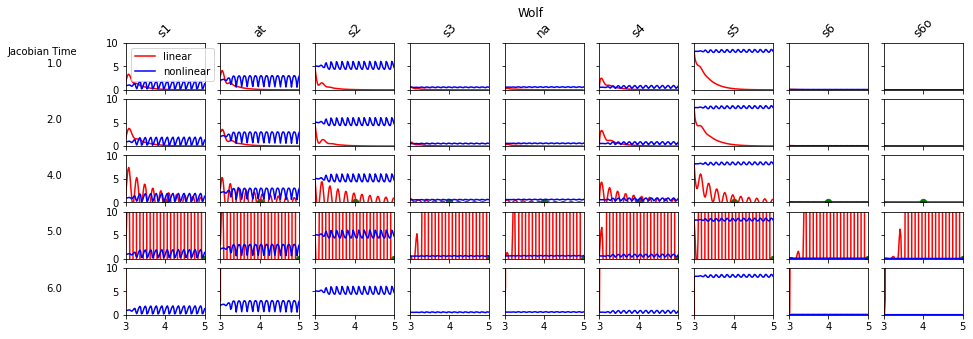

In [35]:
evaluateAccuracy(rr, [1, 2, 4, 5, 6], suptitle="Wolf", start_time=3, end_time=5, y_max=10)

# Model 193

In [36]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000193.2?filename=BIOMD0000000193_url.xml")

In [37]:
ctlsb_193 = ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000193.2?filename=BIOMD0000000193_url.xml")

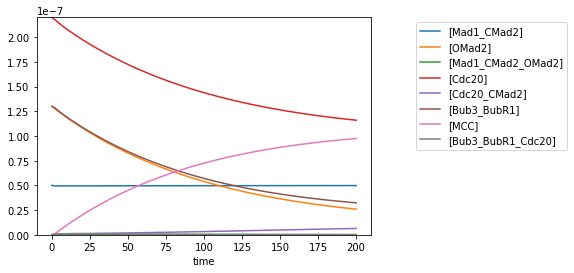

In [38]:
ctlsb_193.plotTrueModel(end_time=200, legend_crd=(1.6, 1))

In [39]:
print(ctlsb_193.antimony)

// Created by libAntimony v2.12.0
model *KDM()

  // Compartments and Species:
  compartment Cytoplasm;
  species Mad1_CMad2 in Cytoplasm, OMad2 in Cytoplasm, Mad1_CMad2_OMad2 in Cytoplasm;
  species Cdc20 in Cytoplasm, Cdc20_CMad2 in Cytoplasm, Bub3_BubR1 in Cytoplasm;
  species MCC in Cytoplasm, Bub3_BubR1_Cdc20 in Cytoplasm;

  // Reactions:
  R1: Mad1_CMad2 + OMad2 -> Mad1_CMad2_OMad2; Cytoplasm*(u*k1f*Mad1_CMad2*OMad2 - k1r*Mad1_CMad2_OMad2);
  R2: Mad1_CMad2_OMad2 + Cdc20 => Mad1_CMad2 + Cdc20_CMad2; Cytoplasm*u*k2f*Mad1_CMad2_OMad2*Cdc20;
  R3: Cdc20_CMad2 => Cdc20 + OMad2; Cytoplasm*k3f*Cdc20_CMad2;
  R4: Cdc20_CMad2 + Bub3_BubR1 -> MCC; Cytoplasm*(u*k4f*Cdc20_CMad2*Bub3_BubR1 - k4r*MCC);
  R5: Bub3_BubR1 + Cdc20 -> Bub3_BubR1_Cdc20; Cytoplasm*(u*k5f*Bub3_BubR1*Cdc20 - k5r*Bub3_BubR1_Cdc20);
  R6: OMad2 + Cdc20 => Cdc20_CMad2; Cytoplasm*kf6*OMad2*Cdc20;

  // Events:
  mt_attachment: at time > 2000: u = const_val_0;

  // Species initializations:
  Mad1_CMad2 = 5e-08;
  Mad1_CM

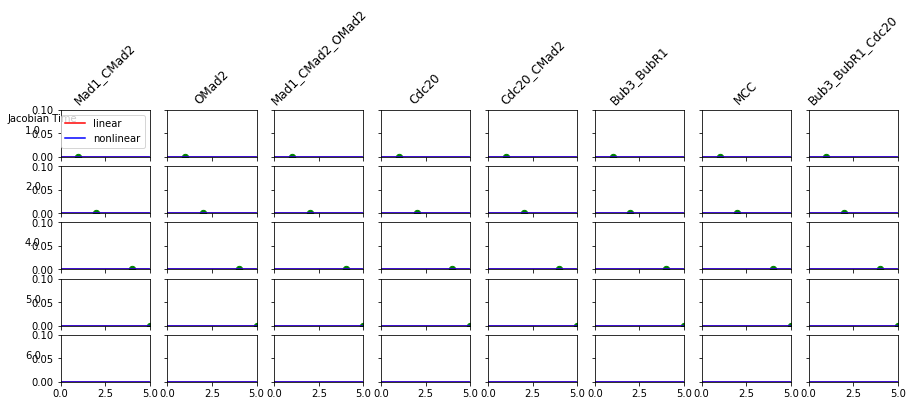

In [40]:
evaluateAccuracy(rr, [1, 2, 4, 5, 6], end_time=5, y_max=0.1)

# Model 816

In [41]:
rr = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000816.5?filename=model.xml")

In [42]:
ctlsb_816 = ControlSBML(rr)

In [43]:
print(ctlsb_816.antimony)

// Created by libAntimony v2.12.0
function Function_for_Tumor_Cell_elimination(k0, c_kill, I, U, T, N)
  (k0 + c_kill*I)*U*T/N;
end

Function_for_Tumor_Cell_elimination is "Function for Tumor Cell elimination"

function Function_for_Tumor_Cell_infection(beta, U, V, N)
  beta*U*V/N;
end

Function_for_Tumor_Cell_infection is "Function for Tumor Cell infection"

function Function_for_natural_decay_of_virus(delta_V, V)
  delta_V*V;
end

Function_for_natural_decay_of_virus is "Function for natural decay of virus"

function Function_for_Activation_of_T_cells__IL12(Chi_A, A)
  Chi_A*A;
end

Function_for_Activation_of_T_cells__IL12 is "Function for Activation of T cells; IL12"

function Function_for_Activation_of_T_cells__4_1BBL(C_T, I)
  C_T*I;
end

Function_for_Activation_of_T_cells__4_1BBL is "Function for Activation of T cells; 4-1BBL"

function Function_for_natural_death_of_naive_T_cells(delta_A, A)
  delta_A*A;
end

Function_for_natural_death_of_naive_T_cells is "Function for natural dea

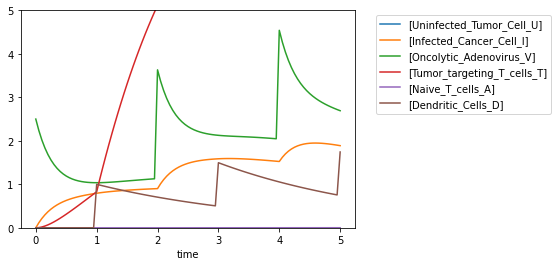

In [44]:
ctlsb_816.plotTrueModel(y_max=5, legend_crd=(1.6, 1))

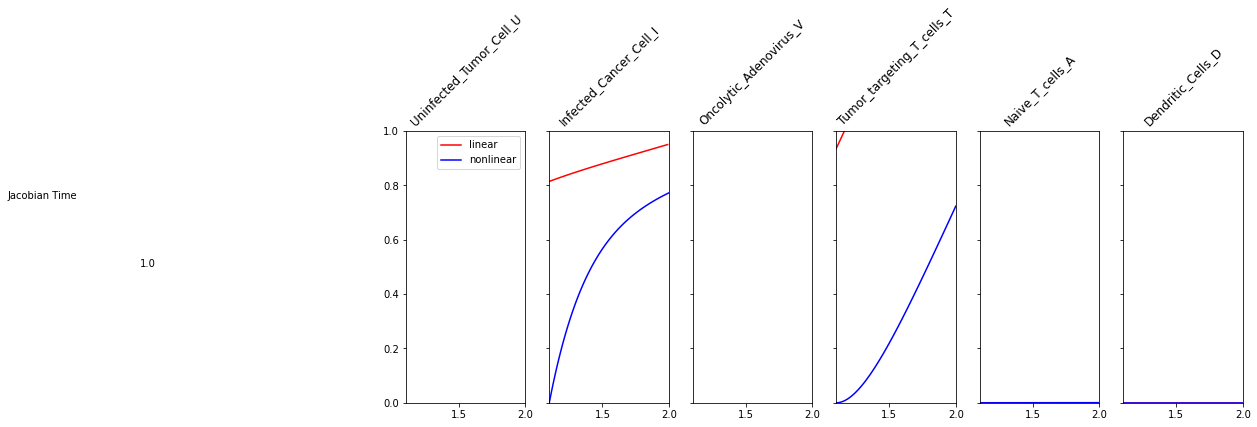

In [45]:
#evaluateAccuracy(rr, [1, 2, 4, 5], end_time=5, ymax=5)
evaluateAccuracy(rr, [1], start_time=1.1, end_time=2, y_max=1)

# Model 823

Insulin levels impact outputs.

In [46]:
ctlsb_823 = ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml")

In [47]:
print(ctlsb_823.antimony)

// Created by libAntimony v2.12.0
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in c

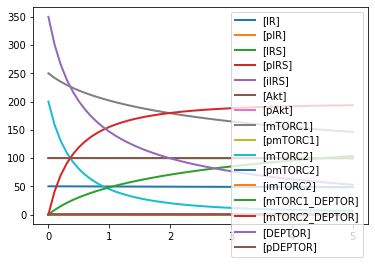

In [48]:
MODEL = """
// Created by libAntimony v2.12.0
function Constant_flux__irreversible(v)
  v;
end

Constant_flux__irreversible is "Constant flux (irreversible)"

function Henri_Michaelis_Menten__irreversible(substrate, Km, V)
  V*substrate/(Km + substrate);
end

Henri_Michaelis_Menten__irreversible is "Henri-Michaelis-Menten (irreversible)"

function HMM_Mod(V, s, m, Km)
  V*s*m/(Km + s);
end

HMM_Mod is "HMM_Mod"

function Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b)
  k11ca*pmTORC1*DEPTOR/(Km11a + pDEPTOR) + k11cb*pmTORC2*DEPTOR/(Km11b + DEPTOR);
end

Function_for_v11 is "Function_for_v11"

function Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b)
  k5ca*pIRS*Akt/(Km5a + Akt) + k5cb*pmTORC2*Akt/(Km5b + Akt);
end

Function_for_v5 is "Function_for_v5"


model *Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR()

  // Compartments and Species:
  compartment compartment_;
  species IR in compartment_, pIR in compartment_, IRS in compartment_, pIRS in compartment_;
  species iIRS in compartment_, Akt in compartment_, pAkt in compartment_;
  species mTORC1 in compartment_, pmTORC1 in compartment_, mTORC2 in compartment_;
  species pmTORC2 in compartment_, imTORC2 in compartment_, mTORC1_DEPTOR in compartment_;
  species mTORC2_DEPTOR in compartment_, DEPTOR in compartment_, pDEPTOR in compartment_;

  // Reactions:
  v1: IR => pIR; compartment_*Henri_Michaelis_Menten__irreversible(IR, Km1, V1);
  v2: pIR => IR; compartment_*Henri_Michaelis_Menten__irreversible(pIR, Km2, V2);
  v3: IRS => pIRS; compartment_*HMM_Mod(k3c, IRS, pIR, Km3);
  v4: pIRS => IRS; compartment_*Henri_Michaelis_Menten__irreversible(pIRS, Km4, V4);
  v5: Akt => pAkt; compartment_*Function_for_v5(k5ca, pIRS, Akt, Km5a, k5cb, pmTORC2, Km5b);
  v6: pAkt => Akt; compartment_*Henri_Michaelis_Menten__irreversible(pAkt, Km6, V6);
  v7: mTORC1 => pmTORC1; compartment_*HMM_Mod(k7c, mTORC1, pAkt, Km7);
  v8: pmTORC1 => mTORC1; compartment_*Henri_Michaelis_Menten__irreversible(pmTORC1, Km8, V8);
  v9: mTORC2 => pmTORC2; compartment_*HMM_Mod(k9c, mTORC2, pIR, Km9);
  v10: pmTORC2 => mTORC2; compartment_*Henri_Michaelis_Menten__irreversible(pmTORC2, Km10, V10);
  v11: DEPTOR => pDEPTOR; compartment_*Function_for_v11(k11ca, pmTORC1, DEPTOR, Km11a, pDEPTOR, k11cb, pmTORC2, Km11b);
  v12: pDEPTOR => DEPTOR; compartment_*Henri_Michaelis_Menten__irreversible(pDEPTOR, Km12, V12);
  v13: mTORC1 + DEPTOR -> mTORC1_DEPTOR; compartment_*(k13f*mTORC1*DEPTOR - k13r*mTORC1_DEPTOR);
  v14: mTORC2 + DEPTOR -> mTORC2_DEPTOR; compartment_*(k14f*mTORC2*DEPTOR - k14r*mTORC2_DEPTOR);
  v15: IRS => iIRS; compartment_*HMM_Mod(k15c, IRS, pmTORC1, Km15);
  v16: iIRS => IRS; compartment_*Henri_Michaelis_Menten__irreversible(iIRS, Km16, V16);
  v17:  => DEPTOR; compartment_*Constant_flux__irreversible(ks17);
  v18: pDEPTOR => ; compartment_*kd18*pDEPTOR;

  // Species initializations:
  IR = 50;
  pIR = 0;
  IRS = 100;
  pIRS = 0;
  iIRS = 0;
  Akt = 100;
  pAkt = 0;
  mTORC1 = 250;
  pmTORC1 = 0;
  mTORC2 = 200;
  pmTORC2 = 0;
  imTORC2 = 0;
  mTORC1_DEPTOR = 0;
  mTORC2_DEPTOR = 0;
  DEPTOR = 350;
  pDEPTOR = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  V1 = 1;
  Km1 = 95;
  V2 = 1;
  Km2 = 35;
  k3c = 0.1;
  Km3 = 50;
  V4 = 1;
  Km4 = 500;
  k5ca = 0.05;
  Km5a = 7;
  k5cb = 1.5;
  Km5b = 4;
  V6 = 2;
  Km6 = 34;
  k7c = 0.1;
  Km7 = 2;
  V8 = 6;
  Km8 = 1;
  k9c = 0.3;
  Km9 = 160;
  V10 = 3;
  Km10 = 7;
  k11ca = 0.1;
  Km11a = 120;
  k11cb = 0.13;
  Km11b = 11;
  V12 = 4;
  Km12 = 7;
  k13f = 0.001;
  k13r = 0.006;
  k14f = 0.007;
  k14r = 0.006;
  k15c = 0.1;
  Km15 = 50;
  V16 = 1;
  Km16 = 50;
  ks17 = 0;
  kd18 = 0;

  // Other declarations:
  const compartment_, V1, Km1, V2, Km2, k3c, Km3, V4, Km4, k5ca, Km5a, k5cb;
  const Km5b, V6, Km6, k7c, Km7, V8, Km8, k9c, Km9, V10, Km10, k11ca, Km11a;
  const k11cb, Km11b, V12, Km12, k13f, k13r, k14f, k14r, k15c, Km15, V16;
  const Km16, ks17, kd18;

  // Unit definitions:
  unit volume = 1e-3 litre;
  unit substance = 1e-3 mole;

  // CV terms:
  compartment_ hypernym "http://identifiers.org/ncit/C48694"
  IR identity "http://identifiers.org/pr/PR:000009064"
  pIR hypernym "http://identifiers.org/pr/PR:000009064"
  IRS identity "http://identifiers.org/ncit/C28474"
  pIRS hypernym "http://identifiers.org/ncit/C28474"
  iIRS hypernym "http://identifiers.org/ncit/C28474"
  Akt identity "http://identifiers.org/pr/PR:000029189"
  pAkt hypernym "http://identifiers.org/pr/PR:000029189"
  mTORC1 hypernym "http://identifiers.org/ncit/C96314"
  pmTORC1 hypernym "http://identifiers.org/ncit/C96314"
  mTORC2 identity "http://identifiers.org/ncit/C96315"
  pmTORC2 hypernym "http://identifiers.org/ncit/C96315"
  imTORC2 hypernym "http://identifiers.org/ncit/C96315"
  mTORC1_DEPTOR part "http://identifiers.org/ncit/C96314"
  mTORC1_DEPTOR part "http://identifiers.org/ncit/C101595"
  mTORC2_DEPTOR part "http://identifiers.org/ncit/C101595"
  mTORC2_DEPTOR part "http://identifiers.org/ncit/mTORC2"
  DEPTOR identity "http://identifiers.org/ncit/C101595"
  pDEPTOR hypernym "http://identifiers.org/ncit/C101595"
  v1 hypernym "http://identifiers.org/go/GO:0016310"
  v2 hypernym "http://identifiers.org/go/GO:0016311"
  v3 hypernym "http://identifiers.org/go/GO:0016310"
  v4 hypernym "http://identifiers.org/go/GO:0016311"
  v5 hypernym "http://identifiers.org/go/GO:0016310"
  v6 hypernym "http://identifiers.org/go/GO:0016311"
  v7 hypernym "http://identifiers.org/go/GO:0016310"
  v8 hypernym "http://identifiers.org/go/GO:0016311"
  v9 hypernym "http://identifiers.org/go/GO:0016310"
  v10 hypernym "http://identifiers.org/go/GO:0016311"
  v11 hypernym "http://identifiers.org/go/GO:0016310"
  v12 hypernym "http://identifiers.org/go/GO:0016311"
  v13 hypernym "http://identifiers.org/ncit/C18469"
  v14 hypernym "http://identifiers.org/ncit/C18469"
  v15 hypernym "http://identifiers.org/ncit/C16983"
  v15 hypernym "http://identifiers.org/sbo/SBO:0000169"
  v16 hypernym "http://identifiers.org/ncit/C21018"
  v17 hypernym "http://identifiers.org/ncit/C80450"
  v18 hypernym "http://identifiers.org/ncit/C61559"
end

Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR is "Varusai2018 - Dynamic modelling of the mTOR signalling network reveals complex emergent behaviours conferred by DEPTOR"

Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR description "http://identifiers.org/pubmed/29330362"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR model_entity_is "http://identifiers.org/biomodels.db/MODEL1909250003",
                                                                                                                                       "http://identifiers.org/biomodels.db/BIOMD0000000823"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR property "http://identifiers.org/mamo/MAMO_0000046"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR property "http://identifiers.org/pw/PW:0000180"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR property "http://identifiers.org/ncit/C101595"
Varusai2018___Dynamic_modelling_of_the_mTOR_signalling_network_reveals_complex_emergent_behaviours_conferred_by_DEPTOR taxon "http://identifiers.org/taxonomy/9606"
"""

rr = te.loada(MODEL)
rr.plot(rr.simulate())

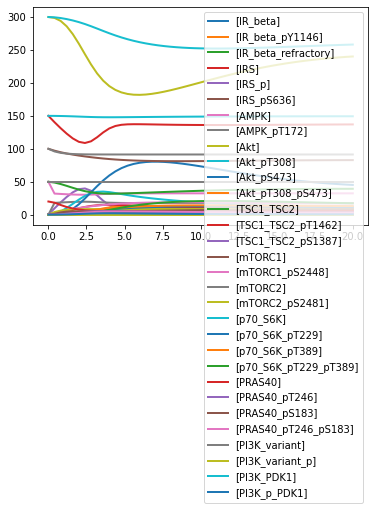

In [82]:
MODEL_640 = """
// Created by libAntimony v2.12.0
function function_6(IRS_p, IRS_p_phos_by_p70_S6K_pT229_pT389, p70_S6K_pT229_pT389)
  IRS_p_phos_by_p70_S6K_pT229_pT389*IRS_p*p70_S6K_pT229_pT389;
end

function_6 is "Function for reaction_8"

function function_3(Amino_Acids, mTORC2, mTORC2_S2481_phos_by_Amino_Acids)
  mTORC2_S2481_phos_by_Amino_Acids*mTORC2*Amino_Acids;
end

function_3 is "Function for reaction_3"

function function_14(Akt_S473_phos_by_mTORC2_pS2481_second, Akt_pT308, mTORC2_pS2481)
  Akt_S473_phos_by_mTORC2_pS2481_second*Akt_pT308*mTORC2_pS2481;
end

function_14 is "Function for reaction_20"

function function_17(TSC1_TSC2, TSC1_TSC2_pS1387, mTORC1_pS2448, mTORC1_pS2448_dephos_by_TSC1_TSC2)
  mTORC1_pS2448_dephos_by_TSC1_TSC2*mTORC1_pS2448*(TSC1_TSC2 + TSC1_TSC2_pS1387);
end

function_17 is "Function for reaction_29"

function function_20(PI3K_p_PDK1, p70_S6K, p70_S6K_T229_phos_by_PI3K_p_PDK1_first)
  p70_S6K_T229_phos_by_PI3K_p_PDK1_first*p70_S6K*PI3K_p_PDK1;
end

function_20 is "Function for reaction_33"

function function_19(PI3K_variant_p, mTORC2, mTORC2_S2481_phos_by_PI3K_variant_p)
  mTORC2_S2481_phos_by_PI3K_variant_p*mTORC2*PI3K_variant_p;
end

function_19 is "Function for reaction_31"

function function_2(AMPK, AMPK_T172_phos_by_Amino_Acids, Amino_Acids)
  AMPK_T172_phos_by_Amino_Acids*AMPK*Amino_Acids;
end

function_2 is "Function for reaction_2"

function function_4(IR_beta, IR_beta_phos_by_Insulin, Insulin)
  IR_beta_phos_by_Insulin*IR_beta*Insulin;
end

function_4 is "Function for reaction_4"

function function_23(mTORC1_pS2448, p70_S6K_T389_phos_by_mTORC1_pS2448_second, p70_S6K_pT229)
  p70_S6K_T389_phos_by_mTORC1_pS2448_second*p70_S6K_pT229*mTORC1_pS2448;
end

function_23 is "Function for reaction_36"

function function_22(PI3K_p_PDK1, p70_S6K_T229_phos_by_PI3K_p_PDK1_second, p70_S6K_pT389)
  p70_S6K_T229_phos_by_PI3K_p_PDK1_second*p70_S6K_pT389*PI3K_p_PDK1;
end

function_22 is "Function for reaction_35"

function function_16(Akt_pT308, Akt_pT308_pS473, TSC1_TSC2, TSC1_TSC2_T1462_phos_by_Akt_pT308)
  TSC1_TSC2_T1462_phos_by_Akt_pT308*TSC1_TSC2*(Akt_pT308 + Akt_pT308_pS473);
end

function_16 is "Function for reaction_26"

function function_11(Akt, Akt_T308_phos_by_PI3K_p_PDK1_first, PI3K_p_PDK1)
  Akt_T308_phos_by_PI3K_p_PDK1_first*Akt*PI3K_p_PDK1;
end

function_11 is "Function for reaction_17"

function function_27(PRAS40_S183_phos_by_mTORC1_pS2448_second, PRAS40_pT246, mTORC1_pS2448)
  PRAS40_S183_phos_by_mTORC1_pS2448_second*PRAS40_pT246*mTORC1_pS2448;
end

function_27 is "Function for reaction_44"

function function_26(Akt_pT308, Akt_pT308_pS473, PRAS40_T246_phos_by_Akt_pT308_second, PRAS40_pS183)
  PRAS40_T246_phos_by_Akt_pT308_second*PRAS40_pS183*(Akt_pT308 + Akt_pT308_pS473);
end

function_26 is "Function for reaction_43"

function function_7(IRS, IRS_phos_by_p70_S6K_pT229_pT389, p70_S6K_pT229_pT389)
  IRS_phos_by_p70_S6K_pT229_pT389*IRS*p70_S6K_pT229_pT389;
end

function_7 is "Function for reaction_9"

function function_15(AMPK_pT172, TSC1_TSC2, TSC1_TSC2_S1387_phos_by_AMPK_pT172)
  TSC1_TSC2_S1387_phos_by_AMPK_pT172*TSC1_TSC2*AMPK_pT172;
end

function_15 is "Function for reaction_25"

function function_9(IR_beta_pY1146, PI3K_variant, PI3K_variant_phos_by_IR_beta_pY1146)
  PI3K_variant_phos_by_IR_beta_pY1146*PI3K_variant*IR_beta_pY1146;
end

function_9 is "Function for reaction_14"

function function_12(Akt, Akt_S473_phos_by_mTORC2_pS2481_first, mTORC2_pS2481)
  Akt_S473_phos_by_mTORC2_pS2481_first*Akt*mTORC2_pS2481;
end

function_12 is "Function for reaction_18"

function function_18(Amino_Acids, mTORC1, mTORC1_S2448_activation_by_Amino_Acids)
  mTORC1_S2448_activation_by_Amino_Acids*mTORC1*Amino_Acids;
end

function_18 is "Function for reaction_30"

function function_10(AMPK, AMPK_T172_phos, IRS_p)
  AMPK_T172_phos*AMPK*IRS_p;
end

function_10 is "Function for reaction_15"

function function_13(Akt_T308_phos_by_PI3K_p_PDK1_second, Akt_pS473, PI3K_p_PDK1)
  Akt_T308_phos_by_PI3K_p_PDK1_second*Akt_pS473*PI3K_p_PDK1;
end

function_13 is "Function for reaction_19"

function function_8(IRS_p, PI3K_PDK1, PI3K_PDK1_phos_by_IRS_p)
  PI3K_PDK1_phos_by_IRS_p*PI3K_PDK1*IRS_p;
end

function_8 is "Function for reaction_12"

function function_21(mTORC1_pS2448, p70_S6K, p70_S6K_T389_phos_by_mTORC1_pS2448_first)
  p70_S6K_T389_phos_by_mTORC1_pS2448_first*p70_S6K*mTORC1_pS2448;
end

function_21 is "Function for reaction_34"

function function_5(IRS, IRS_phos_by_IR_beta_pY1146, IR_beta_pY1146)
  IRS_phos_by_IR_beta_pY1146*IRS*IR_beta_pY1146;
end

function_5 is "Function for reaction_7"

function function_24(PRAS40, PRAS40_S183_phos_by_mTORC1_pS2448_first, mTORC1_pS2448)
  PRAS40_S183_phos_by_mTORC1_pS2448_first*PRAS40*mTORC1_pS2448;
end

function_24 is "Function for reaction_41"

function function_25(Akt_pT308, Akt_pT308_pS473, PRAS40, PRAS40_T246_phos_by_Akt_pT308_first)
  PRAS40_T246_phos_by_Akt_pT308_first*PRAS40*(Akt_pT308 + Akt_pT308_pS473);
end

function_25 is "Function for reaction_42"

function function_1(Amino_Acids, IRS, IRS_phos_by_Amino_Acids)
  IRS_phos_by_Amino_Acids*IRS*Amino_Acids;
end

function_1 is "Function for reaction_1"


model *MODEL1702270000()

  // Compartments and Species:
  compartment Cell;
  species IR_beta in Cell, IR_beta_pY1146 in Cell, IR_beta_refractory in Cell;
  species IRS in Cell, IRS_p in Cell, IRS_pS636 in Cell, AMPK in Cell, AMPK_pT172 in Cell;
  species Akt in Cell, Akt_pT308 in Cell, Akt_pS473 in Cell, Akt_pT308_pS473 in Cell;
  species TSC1_TSC2 in Cell, TSC1_TSC2_pT1462 in Cell, TSC1_TSC2_pS1387 in Cell;
  species mTORC1 in Cell, mTORC1_pS2448 in Cell, mTORC2 in Cell, mTORC2_pS2481 in Cell;
  species p70_S6K in Cell, p70_S6K_pT229 in Cell, p70_S6K_pT389 in Cell, p70_S6K_pT229_pT389 in Cell;
  species PRAS40 in Cell, PRAS40_pT246 in Cell, PRAS40_pS183 in Cell, PRAS40_pT246_pS183 in Cell;
  species PI3K_variant in Cell, PI3K_variant_p in Cell, PI3K_PDK1 in Cell;
  species PI3K_p_PDK1 in Cell, $Insulin in Cell, $Amino_Acids in Cell, $IR_beta_pY1146_obs in Cell;
  species $IRS_pS636_obs in Cell, $AMPK_pT172_obs in Cell, $Akt_pT308_obs in Cell;
  species $Akt_pS473_obs in Cell, $TSC1_TSC2_pS1387_obs in Cell, $mTOR_pS2448_obs in Cell;
  species $mTOR_pS2481_obs in Cell, $p70_S6K_pT229_obs in Cell, $p70_S6K_pT389_obs in Cell;
  species $PRAS40_pT246_obs in Cell, $PRAS40_pS183_obs in Cell;

  // Assignment Rules:
  Insulin := piecewise(0, time < 0, 0); # Has impact
  Amino_Acids := piecewise(0, time < 0, 5);
  IR_beta_pY1146_obs := IR_beta_pY1146;
  IRS_pS636_obs := IRS_pS636;
  AMPK_pT172_obs := AMPK_pT172;
  Akt_pT308_obs := Akt_pT308 + Akt_pT308_pS473;
  Akt_pS473_obs := Akt_pS473 + Akt_pT308_pS473;
  TSC1_TSC2_pS1387_obs := TSC1_TSC2_pS1387;
  mTOR_pS2448_obs := mTORC1_pS2448;
  mTOR_pS2481_obs := mTORC2_pS2481;
  p70_S6K_pT229_obs := p70_S6K_pT229 + p70_S6K_pT229_pT389;
  p70_S6K_pT389_obs := p70_S6K_pT389 + p70_S6K_pT229_pT389;
  PRAS40_pT246_obs := PRAS40_pT246 + PRAS40_pT246_pS183;
  PRAS40_pS183_obs := PRAS40_pS183 + PRAS40_pT246_pS183;

  // Reactions:
  reaction_1: IRS => IRS_p; Cell*function_1(Amino_Acids, IRS, IRS_phos_by_Amino_Acids);
  reaction_2: AMPK => AMPK_pT172; Cell*function_2(AMPK, AMPK_T172_phos_by_Amino_Acids, Amino_Acids);
  reaction_3: mTORC2 => mTORC2_pS2481; Cell*function_3(Amino_Acids, mTORC2, mTORC2_S2481_phos_by_Amino_Acids);
  reaction_4: IR_beta => IR_beta_pY1146; Cell*function_4(IR_beta, IR_beta_phos_by_Insulin, Insulin);
  reaction_5: IR_beta_pY1146 => IR_beta_refractory; Cell*IR_beta_pY1146_dephos*IR_beta_pY1146;
  reaction_6: IR_beta_refractory => IR_beta; Cell*IR_beta_ready*IR_beta_refractory;
  reaction_7: IRS => IRS_p; Cell*function_5(IRS, IRS_phos_by_IR_beta_pY1146, IR_beta_pY1146);
  reaction_8: IRS_p => IRS_pS636; Cell*function_6(IRS_p, IRS_p_phos_by_p70_S6K_pT229_pT389, p70_S6K_pT229_pT389);
  reaction_9: IRS => IRS_pS636; Cell*function_7(IRS, IRS_phos_by_p70_S6K_pT229_pT389, p70_S6K_pT229_pT389);
  reaction_10: IRS_pS636 => IRS; Cell*IRS_pS636_turnover*IRS_pS636;
  reaction_11: PI3K_p_PDK1 => PI3K_PDK1; Cell*PI3K_p_PDK1_dephos*PI3K_p_PDK1;
  reaction_12: PI3K_PDK1 => PI3K_p_PDK1; Cell*function_8(IRS_p, PI3K_PDK1, PI3K_PDK1_phos_by_IRS_p);
  reaction_13: PI3K_variant_p => PI3K_variant; Cell*PI3K_variant_p_dephos*PI3K_variant_p;
  reaction_14: PI3K_variant => PI3K_variant_p; Cell*function_9(IR_beta_pY1146, PI3K_variant, PI3K_variant_phos_by_IR_beta_pY1146);
  reaction_15: AMPK => AMPK_pT172; Cell*function_10(AMPK, AMPK_T172_phos, IRS_p);
  reaction_16: AMPK_pT172 => AMPK; Cell*AMPK_pT172_dephos*AMPK_pT172;
  reaction_17: Akt => Akt_pT308; Cell*function_11(Akt, Akt_T308_phos_by_PI3K_p_PDK1_first, PI3K_p_PDK1);
  reaction_18: Akt => Akt_pS473; Cell*function_12(Akt, Akt_S473_phos_by_mTORC2_pS2481_first, mTORC2_pS2481);
  reaction_19: Akt_pS473 => Akt_pT308_pS473; Cell*function_13(Akt_T308_phos_by_PI3K_p_PDK1_second, Akt_pS473, PI3K_p_PDK1);
  reaction_20: Akt_pT308 => Akt_pT308_pS473; Cell*function_14(Akt_S473_phos_by_mTORC2_pS2481_second, Akt_pT308, mTORC2_pS2481);
  reaction_21: Akt_pT308 => Akt; Cell*Akt_pT308_dephos_first*Akt_pT308;
  reaction_22: Akt_pS473 => Akt; Cell*Akt_pS473_dephos_first*Akt_pS473;
  reaction_23: Akt_pT308_pS473 => Akt_pS473; Cell*Akt_pT308_dephos_second*Akt_pT308_pS473;
  reaction_24: Akt_pT308_pS473 => Akt_pT308; Cell*Akt_pS473_dephos_second*Akt_pT308_pS473;
  reaction_25: TSC1_TSC2 => TSC1_TSC2_pS1387; Cell*function_15(AMPK_pT172, TSC1_TSC2, TSC1_TSC2_S1387_phos_by_AMPK_pT172);
  reaction_26: TSC1_TSC2 => TSC1_TSC2_pT1462; Cell*function_16(Akt_pT308, Akt_pT308_pS473, TSC1_TSC2, TSC1_TSC2_T1462_phos_by_Akt_pT308);
  reaction_27: TSC1_TSC2_pS1387 => TSC1_TSC2; Cell*TSC1_TSC2_pS1387_dephos*TSC1_TSC2_pS1387;
  reaction_28: TSC1_TSC2_pT1462 => TSC1_TSC2; Cell*TSC1_TSC2_pT1462_dephos*TSC1_TSC2_pT1462;
  reaction_29: mTORC1_pS2448 => mTORC1; Cell*function_17(TSC1_TSC2, TSC1_TSC2_pS1387, mTORC1_pS2448, mTORC1_pS2448_dephos_by_TSC1_TSC2);
  reaction_30: mTORC1 => mTORC1_pS2448; Cell*function_18(Amino_Acids, mTORC1, mTORC1_S2448_activation_by_Amino_Acids);
  reaction_31: mTORC2 => mTORC2_pS2481; Cell*function_19(PI3K_variant_p, mTORC2, mTORC2_S2481_phos_by_PI3K_variant_p);
  reaction_32: mTORC2_pS2481 => mTORC2; Cell*mTORC2_pS2481_dephos*mTORC2_pS2481;
  reaction_33: p70_S6K => p70_S6K_pT229; Cell*function_20(PI3K_p_PDK1, p70_S6K, p70_S6K_T229_phos_by_PI3K_p_PDK1_first);
  reaction_34: p70_S6K => p70_S6K_pT389; Cell*function_21(mTORC1_pS2448, p70_S6K, p70_S6K_T389_phos_by_mTORC1_pS2448_first);
  reaction_35: p70_S6K_pT389 => p70_S6K_pT229_pT389; Cell*function_22(PI3K_p_PDK1, p70_S6K_T229_phos_by_PI3K_p_PDK1_second, p70_S6K_pT389);
  reaction_36: p70_S6K_pT229 => p70_S6K_pT229_pT389; Cell*function_23(mTORC1_pS2448, p70_S6K_T389_phos_by_mTORC1_pS2448_second, p70_S6K_pT229);
  reaction_37: p70_S6K_pT229 => p70_S6K; Cell*p70_S6K_pT229_dephos_first*p70_S6K_pT229;
  reaction_38: p70_S6K_pT389 => p70_S6K; Cell*p70_S6K_pT389_dephos_first*p70_S6K_pT389;
  reaction_39: p70_S6K_pT229_pT389 => p70_S6K_pT389; Cell*p70_S6K_pT229_dephos_second*p70_S6K_pT229_pT389;
  reaction_40: p70_S6K_pT229_pT389 => p70_S6K_pT229; Cell*p70_S6K_pT389_dephos_second*p70_S6K_pT229_pT389;
  reaction_41: PRAS40 => PRAS40_pS183; Cell*function_24(PRAS40, PRAS40_S183_phos_by_mTORC1_pS2448_first, mTORC1_pS2448);
  reaction_42: PRAS40 => PRAS40_pT246; Cell*function_25(Akt_pT308, Akt_pT308_pS473, PRAS40, PRAS40_T246_phos_by_Akt_pT308_first);
  reaction_43: PRAS40_pS183 => PRAS40_pT246_pS183; Cell*function_26(Akt_pT308, Akt_pT308_pS473, PRAS40_T246_phos_by_Akt_pT308_second, PRAS40_pS183);
  reaction_44: PRAS40_pT246 => PRAS40_pT246_pS183; Cell*function_27(PRAS40_S183_phos_by_mTORC1_pS2448_second, PRAS40_pT246, mTORC1_pS2448);
  reaction_45: PRAS40_pS183 => PRAS40; Cell*PRAS40_pS183_dephos_first*PRAS40_pS183;
  reaction_46: PRAS40_pT246 => PRAS40; Cell*PRAS40_pT246_dephos_first*PRAS40_pT246;
  reaction_47: PRAS40_pT246_pS183 => PRAS40_pT246; Cell*PRAS40_pS183_dephos_second*PRAS40_pT246_pS183;
  reaction_48: PRAS40_pT246_pS183 => PRAS40_pS183; Cell*PRAS40_pT246_dephos_second*PRAS40_pT246_pS183;

  // Species initializations:
  IR_beta = 50;
  IR_beta_pY1146 = 0;
  IR_beta_refractory = 0;
  IRS = 150;  # Doubling has an impact
  IRS_p = 0;
  IRS_pS636 = 0;
  AMPK = 50;
  AMPK_pT172 = 0;
  Akt = 300;
  Akt_pT308 = 0;
  Akt_pS473 = 0;
  Akt_pT308_pS473 = 0;
  TSC1_TSC2 = 50;
  TSC1_TSC2_pT1462 = 0;
  TSC1_TSC2_pS1387 = 0;
  mTORC1 = 100;
  mTORC1_pS2448 = 0;
  mTORC2 = 100;
  mTORC2_pS2481 = 0;
  p70_S6K = 300;
  p70_S6K_pT229 = 0;
  p70_S6K_pT389 = 0;
  p70_S6K_pT229_pT389 = 0;
  PRAS40 = 20;
  PRAS40_pT246 = 0;
  PRAS40_pS183 = 0;
  PRAS40_pT246_pS183 = 0;
  PI3K_variant = 50;
  PI3K_variant_p = 0;
  PI3K_PDK1 = 150; # Doubling and tripling has an impact
  PI3K_p_PDK1 = 0;

  // Compartment initializations:
  Cell = 1;

  // Variable initializations:
  IRS_phos_by_Amino_Acids = 0.0331672;
  AMPK_T172_phos_by_Amino_Acids = 17.6284;
  mTORC2_S2481_phos_by_Amino_Acids = 0.0268658;
  IR_beta_phos_by_Insulin = 0.0203796;
  IR_beta_pY1146_dephos = 0.493514;
  IR_beta_ready = 323.611;
  IRS_phos_by_IR_beta_pY1146 = 2.11894;
  IRS_p_phos_by_p70_S6K_pT229_pT389 = 0.338859859949792;
  IRS_phos_by_p70_S6K_pT229_pT389 = 0.0863775267376444;
  IRS_pS636_turnover = 25;
  AMPK_T172_phos = 0.490602;
  AMPK_pT172_dephos = 165.704;
  Akt_S473_phos_by_mTORC2_pS2481_first = 1.31992e-05;
  Akt_S473_phos_by_mTORC2_pS2481_second = 0.159093;
  Akt_T308_phos_by_PI3K_p_PDK1_first = 7.47437;
  Akt_T308_phos_by_PI3K_p_PDK1_second = 7.47345;
  Akt_pT308_dephos_first = 88.9654;
  Akt_pT308_dephos_second = 88.9639;
  Akt_pS473_dephos_first = 0.376999;
  Akt_pS473_dephos_second = 0.380005;
  TSC1_TSC2_S1387_phos_by_AMPK_pT172 = 0.00175772;
  TSC1_TSC2_T1462_phos_by_Akt_pT308 = 1.52417;
  TSC1_TSC2_pS1387_dephos = 0.25319;
  TSC1_TSC2_pT1462_dephos = 147.239;
  mTORC1_pS2448_dephos_by_TSC1_TSC2 = 0.00869774;
  mTORC1_S2448_activation_by_Amino_Acids = 0.0156992;
  mTORC2_pS2481_dephos = 1.42511;
  mTORC2_S2481_phos_by_PI3K_variant_p = 0.120736;
  p70_S6K_T229_phos_by_PI3K_p_PDK1_first = 0.0133520172873009;
  p70_S6K_T229_phos_by_PI3K_p_PDK1_second = 1.00000002814509e-06;
  p70_S6K_T389_phos_by_mTORC1_pS2448_first = 0.00261303413778722;
  p70_S6K_T389_phos_by_mTORC1_pS2448_second = 0.110720890919343;
  p70_S6K_pT229_dephos_first = 1.00000012897033e-06;
  p70_S6K_pT229_dephos_second = 0.159201353240651;
  p70_S6K_pT389_dephos_first = 1.10036057608758;
  p70_S6K_pT389_dephos_second = 1.10215267954479;
  PRAS40_S183_phos_by_mTORC1_pS2448_first = 0.15881;
  PRAS40_S183_phos_by_mTORC1_pS2448_second = 0.0683009;
  PRAS40_T246_phos_by_Akt_pT308_first = 0.279344;
  PRAS40_T246_phos_by_Akt_pT308_second = 0.279401;
  PRAS40_pS183_dephos_first = 1.8706;
  PRAS40_pS183_dephos_second = 1.88453;
  PRAS40_pT246_dephos_first = 11.8759;
  PRAS40_pT246_dephos_second = 11.876;
  PI3K_p_PDK1_dephos = 0.18913343080532;
  PI3K_PDK1_phos_by_IRS_p = 0.000187226757782201;
  PI3K_variant_p_dephos = 0.108074886441184;
  PI3K_variant_phos_by_IR_beta_pY1146 = 0.000549027801822575;
  scale_IR_beta_pY1146_obs = 1;
  scale_IRS_pS636_obs = 1;
  scale_AMPK_pT172_obs = 1;
  scale_Akt_pT308_obs = 1;
  scale_Akt_pS473_obs = 1;
  scale_TSC1_TSC2_pS1387_obs = 1;
  scale_mTOR_pS2448_obs = 1;
  scale_mTOR_pS2481_obs = 1;
  scale_p70_S6K_pT229_obs = 1;
  scale_p70_S6K_pT389_obs = 1;
  scale_PRAS40_pT246_obs = 1;
  scale_PRAS40_pS183_obs = 1;

  // Other declarations:
  const Cell, IRS_phos_by_Amino_Acids, AMPK_T172_phos_by_Amino_Acids, mTORC2_S2481_phos_by_Amino_Acids;
  const IR_beta_phos_by_Insulin, IR_beta_pY1146_dephos, IR_beta_ready, IRS_phos_by_IR_beta_pY1146;
  const IRS_p_phos_by_p70_S6K_pT229_pT389, IRS_phos_by_p70_S6K_pT229_pT389;
  const IRS_pS636_turnover, AMPK_T172_phos, AMPK_pT172_dephos, Akt_S473_phos_by_mTORC2_pS2481_first;
  const Akt_S473_phos_by_mTORC2_pS2481_second, Akt_T308_phos_by_PI3K_p_PDK1_first;
  const Akt_T308_phos_by_PI3K_p_PDK1_second, Akt_pT308_dephos_first, Akt_pT308_dephos_second;
  const Akt_pS473_dephos_first, Akt_pS473_dephos_second, TSC1_TSC2_S1387_phos_by_AMPK_pT172;
  const TSC1_TSC2_T1462_phos_by_Akt_pT308, TSC1_TSC2_pS1387_dephos, TSC1_TSC2_pT1462_dephos;
  const mTORC1_pS2448_dephos_by_TSC1_TSC2, mTORC1_S2448_activation_by_Amino_Acids;
  const mTORC2_pS2481_dephos, mTORC2_S2481_phos_by_PI3K_variant_p, p70_S6K_T229_phos_by_PI3K_p_PDK1_first;
  const p70_S6K_T229_phos_by_PI3K_p_PDK1_second, p70_S6K_T389_phos_by_mTORC1_pS2448_first;
  const p70_S6K_T389_phos_by_mTORC1_pS2448_second, p70_S6K_pT229_dephos_first;
  const p70_S6K_pT229_dephos_second, p70_S6K_pT389_dephos_first, p70_S6K_pT389_dephos_second;
  const PRAS40_S183_phos_by_mTORC1_pS2448_first, PRAS40_S183_phos_by_mTORC1_pS2448_second;
  const PRAS40_T246_phos_by_Akt_pT308_first, PRAS40_T246_phos_by_Akt_pT308_second;
  const PRAS40_pS183_dephos_first, PRAS40_pS183_dephos_second, PRAS40_pT246_dephos_first;
  const PRAS40_pT246_dephos_second, PI3K_p_PDK1_dephos, PI3K_PDK1_phos_by_IRS_p;
  const PI3K_variant_p_dephos, PI3K_variant_phos_by_IR_beta_pY1146, scale_IR_beta_pY1146_obs;
  const scale_IRS_pS636_obs, scale_AMPK_pT172_obs, scale_Akt_pT308_obs, scale_Akt_pS473_obs;
  const scale_TSC1_TSC2_pS1387_obs, scale_mTOR_pS2448_obs, scale_mTOR_pS2481_obs;
  const scale_p70_S6K_pT229_obs, scale_p70_S6K_pT389_obs, scale_PRAS40_pT246_obs;
  const scale_PRAS40_pS183_obs;

  // Unit definitions:
  unit volume = dimensionless;
  unit time_unit = 60 second;
  unit substance = dimensionless;

  // Display Names:
  time_unit is "time";

  // SBO terms:
  Cell.sboTerm = 290

  // CV terms:
  Cell property "http://identifiers.org/fma/FMA:68646"
  IR_beta hypernym "http://identifiers.org/uniprot/P06213"
  IRS hypernym "http://identifiers.org/uniprot/P35569"
  AMPK hypernym "http://identifiers.org/uniprot/Q5EG47"
end

MODEL1702270000 is "DallePezze2016 - Activation of AMPK and mTOR by amino acids"

MODEL1702270000 model_entity_is "http://identifiers.org/biomodels.db/MODEL1702270000"
MODEL1702270000 model_entity_is "http://identifiers.org/biomodels.db/BIOMD0000000640"
MODEL1702270000 description "http://identifiers.org/pubmed/27869123"
MODEL1702270000 taxon "http://identifiers.org/taxonomy/40674"
MODEL1702270000 property "http://identifiers.org/go/GO:0010506",
                         "http://identifiers.org/mamo/MAMO_0000046"
"""
rr = te.loada(MODEL_640)
rr.plot(rr.simulate(0, 20))

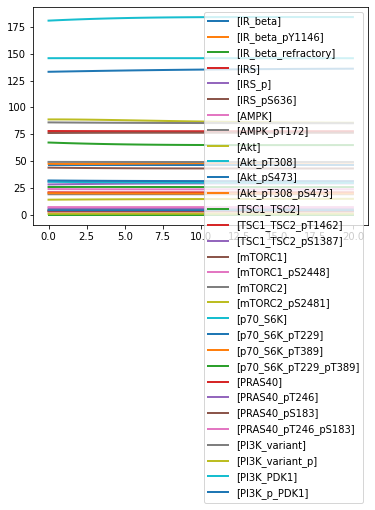

In [80]:
rra.plot(rra.simulate(0, 20))

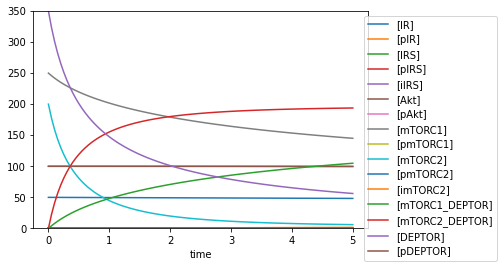

In [63]:
ctlsb_823.set({"ks17": 1})
ctlsb_823.plotTrueModel(legend_crd=(1.4, 1))

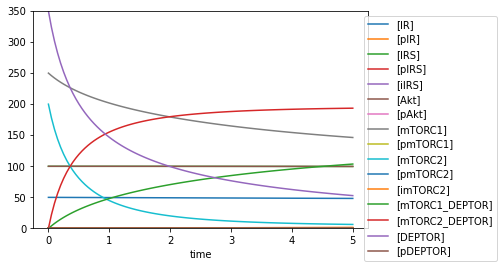

In [64]:
ctlsb_823.set({"ks17": 0, "IR": 50, "Km2": 500 })
ctlsb_823.plotTrueModel(legend_crd=(1.4, 1))

In [65]:
ctlsb_823.get("Km1")

95.0

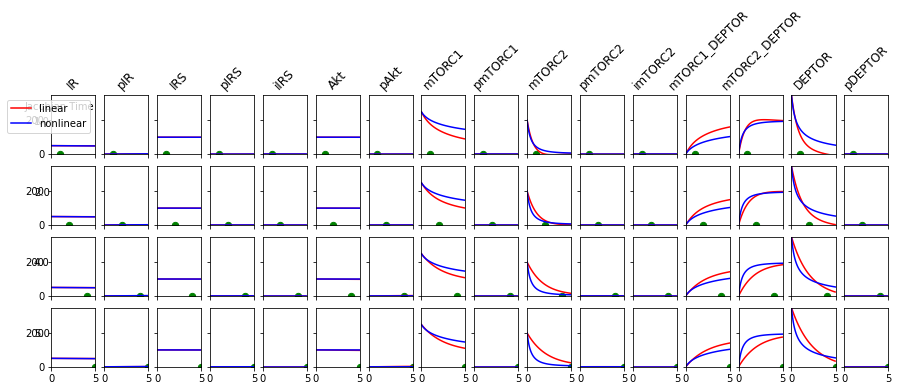

In [66]:
evaluateAccuracy(ctlsb_823.roadrunner, [1, 2, 4, 5], end_time=5)

# Model 640

In [67]:
url_640 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000640.2?filename=BIOMD0000000640_url.xml"

In [68]:
symmath = SymmathSBML(url_640)

***Warning. Cannot process rule. Ignoring: piecewise(0, lt(time, 0), 0)
***Warning. Cannot process rule. Ignoring: piecewise(0, lt(time, 0), 1)


In [83]:
symmath.getSystem()

IR_beta                                                                                                                            -0.0203796*IR_beta*Insulin + 323.611*IR_beta_refractory
IR_beta_pY1146                                                                                                                         0.0203796*IR_beta*Insulin - 0.493514*IR_beta_pY1146
IR_beta_refractory                                                                                                                    0.493514*IR_beta_pY1146 - 323.611*IR_beta_refractory
IRS                                                                  -0.0331672*Amino_Acids*IRS - 2.11894*IRS*IR_beta_pY1146 - 0.0863775267376444*IRS*p70_S6K_pT229_pT389 + 25.0*IRS_pS636
IRS_p                                                                                 0.0331672*Amino_Acids*IRS + 2.11894*IRS*IR_beta_pY1146 - 0.338859859949792*IRS_p*p70_S6K_pT229_pT389
IRS_pS636                                                        

In [69]:
pd.set_option("max_colwidth", 300)
symmath.getJacobian()

,IR_beta,IR_beta_pY1146,IR_beta_refractory,IRS,IRS_p,IRS_pS636,AMPK,AMPK_pT172,Akt,Akt_pT308,...,p70_S6K_pT389,p70_S6K_pT229_pT389,PRAS40,PRAS40_pT246,PRAS40_pS183,PRAS40_pT246_pS183,PI3K_variant,PI3K_variant_p,PI3K_PDK1,PI3K_p_PDK1
IR_beta,-0.0203796*Insulin,0,323.611000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IR_beta_pY1146,0.0203796*Insulin,-0.493514000000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IR_beta_refractory,0,0.493514000000000,-323.611000000000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IRS,0,-2.11894*IRS,0,-0.0331672*Amino_Acids - 2.11894*IR_beta_pY1146 - 0.0863775267376444*p70_S6K_pT229_pT389,0,25.0000000000000,0,0,0,0,...,0,-0.0863775267376444*IRS,0,0,0,0,0,0,0,0
IRS_p,0,2.11894*IRS,0,0.0331672*Amino_Acids + 2.11894*IR_beta_pY1146,-0.338859859949792*p70_S6K_pT229_pT389,0,0,0,0,0,...,0,-0.338859859949792*IRS_p,0,0,0,0,0,0,0,0
IRS_pS636,0,0,0,0.0863775267376444*p70_S6K_pT229_pT389,0.338859859949792*p70_S6K_pT229_pT389,-25.0000000000000,0,0,0,0,...,0,0.0863775267376444*IRS + 0.338859859949792*IRS_p,0,0,0,0,0,0,0,0
AMPK,0,0,0,0,-0.490602*AMPK,0,-17.6284*Amino_Acids - 0.490602*IRS_p,165.704000000000,0,0,...,0,0,0,0,0,0,0,0,0,0
AMPK_pT172,0,0,0,0,0.490602*AMPK,0,17.6284*Amino_Acids + 0.490602*IRS_p,-165.704000000000,0,0,...,0,0,0,0,0,0,0,0,0,0
Akt,0,0,0,0,0,0,0,0,-7.47437*PI3K_p_PDK1 - 1.31992e-5*mTORC2_pS2481,88.9654000000000,...,0,0,0,0,0,0,0,0,0,-7.47437*Akt
Akt_pT308,0,0,0,0,0,0,0,0,7.47437*PI3K_p_PDK1,-0.159093*mTORC2_pS2481 - 88.9654,...,0,0,0,0,0,0,0,0,0,7.47437*Akt


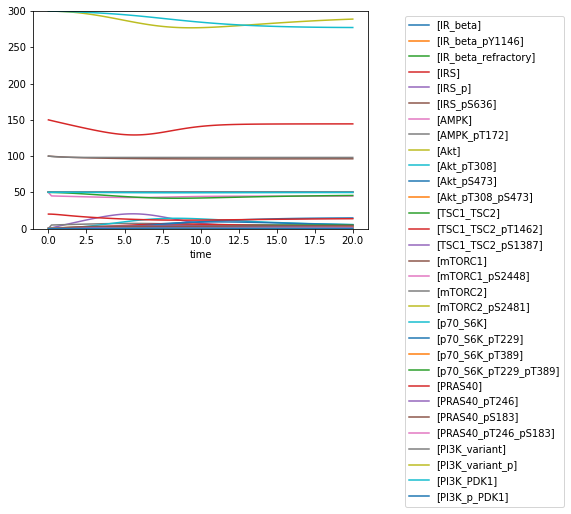

In [70]:
def runModel(url, legend_crd=(1.6, 1), is_plot=True, is_accuracy=True, **kwargs):
    ctlsb = ControlSBML(url)
    ctlsb.plotTrueModel(legend_crd=legend_crd, is_plot=is_plot, **kwargs)
    if is_accuracy:
        evaluateAccuracy(ctlsb.roadrunner, [1, 2, 4, 5], end_time=5, is_plot=is_plot)
    return ctlsb
    
# Tests
ctlsb_640a = runModel(url_640, is_plot=False, is_accuracy=False, end_time=20)

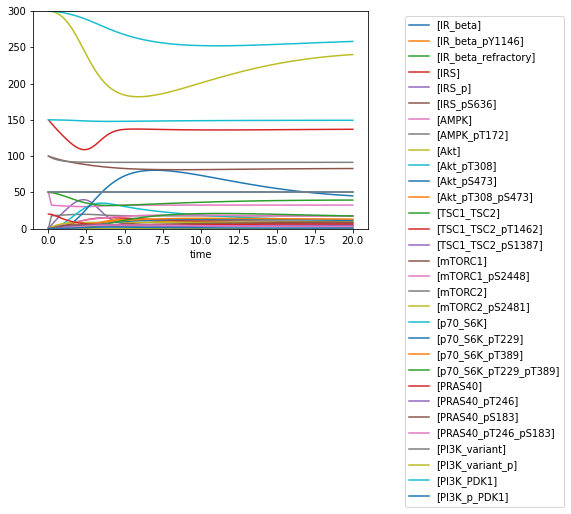

In [71]:
ctlsb_640b = runModel(MODEL_640, is_plot=False, end_time=20, is_accuracy=False)

In [72]:
ctlsb_640a.setTime(0)
jaca= ctlsb_640a.jacobian

ctlsb_640a.setTime(5)
jacb= ctlsb_640a.jacobian

np.sqrt(np.sum(jaca - jacb)**2)

IR_beta                0.000000e+00
IR_beta_pY1146         0.000000e+00
IR_beta_refractory     0.000000e+00
IRS                    0.000000e+00
IRS_p                  0.000000e+00
IRS_pS636              0.000000e+00
AMPK                   0.000000e+00
AMPK_pT172             0.000000e+00
Akt                    8.157266e-17
Akt_pT308              7.105427e-15
Akt_pS473              4.440892e-16
Akt_pT308_pS473        1.776357e-15
TSC1_TSC2              8.812395e-16
TSC1_TSC2_pT1462       0.000000e+00
TSC1_TSC2_pS1387       0.000000e+00
mTORC1                 0.000000e+00
mTORC1_pS2448          2.775558e-17
mTORC2                 0.000000e+00
mTORC2_pS2481          0.000000e+00
p70_S6K                0.000000e+00
p70_S6K_pT229          0.000000e+00
p70_S6K_pT389          9.373436e-17
p70_S6K_pT229_pT389    5.551115e-17
PRAS40                 1.110223e-16
PRAS40_pT246           4.718448e-16
PRAS40_pS183           0.000000e+00
PRAS40_pT246_pS183     0.000000e+00
PI3K_variant           0.000

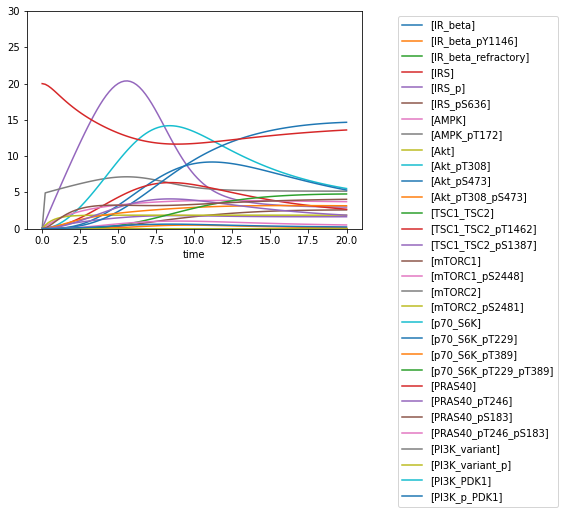

In [74]:
ctlsb_640a.plotTrueModel(end_time=20, legend_crd=(1.6, 1),y_max=30)

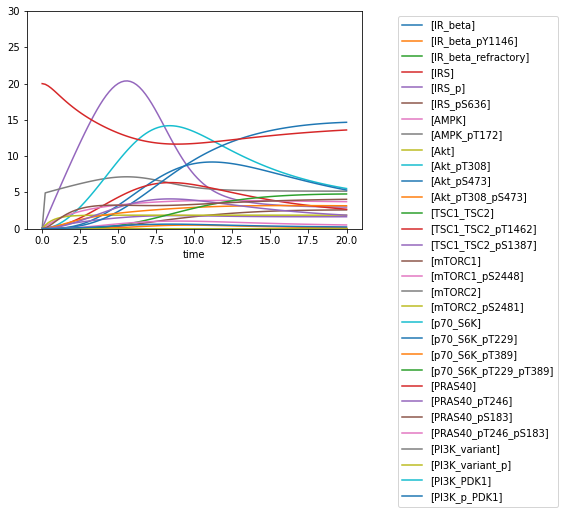

In [75]:
ctlsb_640a.plotTrueModel(end_time=20, legend_crd=(1.6, 1),y_max=30)

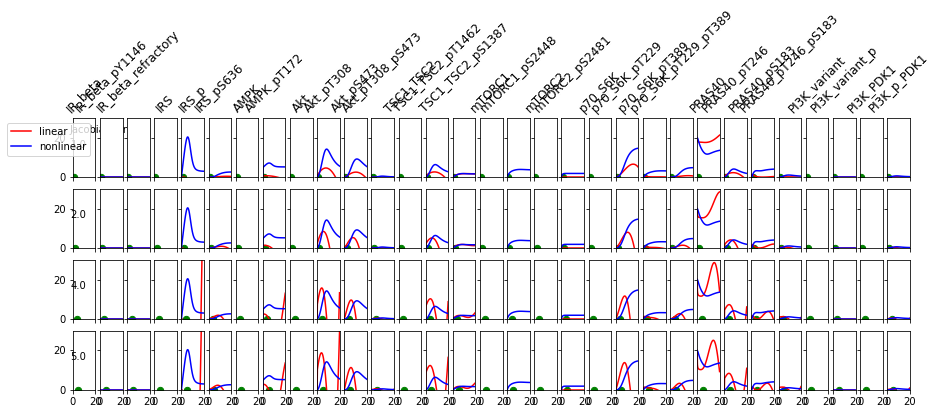

In [76]:
evaluateAccuracy(ctlsb_640a.roadrunner, [1, 2, 4, 5], end_time=20, y_max=30)

In [ ]:
#evaluateAccuracy(ctlsb_640.roadrunner, [1, 2, 4, 5], end_time=20, y_max=30)
evaluateAccuracy(MODEL_640, [1, 2, 4, 5], end_time=20, y_max=30)

In [ ]:
print(ctlsb_640.antimony)

In [ ]:
rr = te.loada(MODEL_640)
rr.plot(rr.simulate(0, 20))

## Notebook on this model
1. Background and content of the model
1. Accuracy of linear approximation
1. Effectors